In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
import itertools
from scipy.optimize import minimize, least_squares
from scipy.optimize import NonlinearConstraint
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from itertools import permutations, product

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl

plt.style.use('style.mpl')

In [4]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib as mpl

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

In [5]:
eps = 1e-10
tau = 1e-4

In [6]:
ZC_org = 2.

In [7]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = (NAD ** ZC_org) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    # dNADH = 2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = (S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP)
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

## Parameters

In [8]:
# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

# Default params: reliance on respiration.
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

### Initial conditions

In [9]:
# micromolar concentrations
Corg0 = 1e1
NADH0 = 1e1
O20 = 1e1
ATP0 = 1e1

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [10]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 2, 1000 )
S6 = 1.

# Full figure 1, minus schematic Fig. 1A

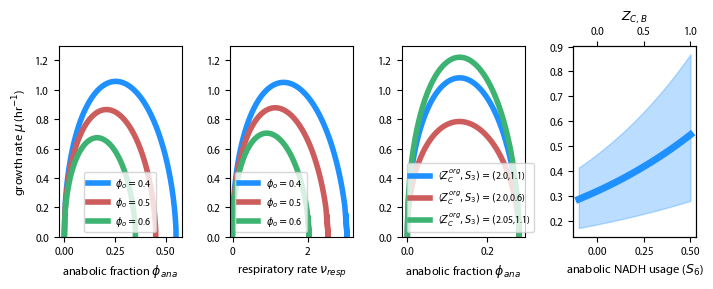

In [16]:
# Create the figure
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(7.24, 3.0))

##############################################
## Fig. 1B
##############################################
plt.sca(axs[0])
plt.ylabel('growth rate ' + r'$\mu$' + ' (hr$^{-1}$)')
plt.xlabel('anabolic fraction ' + r'$\phi_{ana}$')

cs = ['dodgerblue', 'indianred', 'mediumseagreen']
legend_elements = []

# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

# Default params: reliance on respiration.
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass
for indx, t_phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    mus = []
    phianas = []
    phi_o = t_phi_o
    phi_resp = 0.05

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 1.

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    plt.plot( phianas, mus, lw=4, c=cs[indx] )
    legend_elements.append(r'$\phi_o = $' + str(t_phi_o))
plt.ylim(0.0, 1.3)
plt.legend(legend_elements, loc='best')


##############################################
## Fig. 1C
##############################################
plt.sca(axs[1])
plt.ylabel( '')
plt.xlabel( 'respiratory rate ' + r'$\nu_{resp}$' )

# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

# Default params: reliance on respiration.
ZC_org = 2  # NADH yield (ZC) of carbon source
S4 = 7.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.3    # reduction coefficient of biomass
phi_o = 0.45

tau = 1e-3

cs = ['dodgerblue', 'indianred', 'mediumseagreen']
legend_elements = []

cats_to_sample = np.linspace(0.0004, 0.5, 1)
resps_to_sample = np.linspace(0.0, 0.6, 100)

for indx, phi_o in enumerate(np.linspace(0.4, 0.6, 3)):
    for phi_cat in cats_to_sample:
        allmus, allphis, allnuresps = [], [], []
        for phi_resp in resps_to_sample:
            phi_ana = 1-phi_cat-phi_resp-phi_o

            y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
            NUM_METS = len(y0)

            # Evaluation time
            TFINAL = 1e6
            t = np.logspace(-4, 6, 1000 )

            y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T
            if nus[-1,-1] >= 0.0:
                allmus.append(nus[-1, -1])
            else:
                allmus.append(0.0)
            allphis.append([phi_cat, phi_resp, phi_ana])
            allnuresps.append(nus[-1,1])
            if phi_resp == 0.0:
                allnuresps.append(allnuresps[-1]+3e-2)
                allmus.append(0.0)
        
        plt.plot( allnuresps, allmus, lw=4, c=cs[indx] )
        legend_elements.append(r'$\phi_o = $' + str(phi_o))

plt.ylim(0.0, 1.3)
plt.xlim(-0.06,3.2)
plt.legend(legend_elements, loc='best')

##############################################
## Fig. 1D
##############################################
plt.sca(axs[2])
plt.ylabel( '')
plt.xlabel( 'anabolic fraction ' + r'$\phi_{ana}$' )

# gammas are in (g s)/(mol) units.
gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200

# For diminishing reliance on respiration.
# S4 = 0.1    # ATP yield of respiration
# S3 = 1.3    # ATP yield of catabolism

# Default params: reliance on respiration.
ZC_org = 2  # NADH yield (ZC) of carbon source
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

tau = 1e-4

cs = ['dodgerblue', 'indianred', 'mediumseagreen']
legend_elements = []
phi_o = 0.6
ZC_org = 2.0

for indx, S3 in enumerate(np.linspace(1.1, 0.6, 2)):
    mus = []
    phianas = []
    phi_resp = 0.12

    for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
        phi_cat = 1-phi_o-phi_resp-t_phi_ana
        phi_ana = t_phi_ana.copy()

        y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000 )
        S6 = 1.

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        phianas.append(t_phi_ana)

    mus.append(0.0)
    phianas.append(t_phi_ana)
    plt.plot( phianas, mus, lw=4, c=cs[indx] )
    legend_elements.append(r'($Z_C^{org}, S_3) = ($' + str(ZC_org) + ',' + str(S3) + ')')

S3 = 1.1
indx += 1
phi_o = 0.6
ZC_org = 2.05
mus = []
phianas = []
phi_resp = 0.12

for t_phi_ana in np.linspace(0.00, 1-phi_o-phi_resp, 200):
    phi_cat = 1-phi_o-phi_resp-t_phi_ana
    phi_ana = t_phi_ana.copy()

    y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000 )
    S6 = 1.

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    phianas.append(t_phi_ana)

mus.append(0.0)
phianas.append(t_phi_ana)
plt.plot( phianas, mus, lw=4, c=cs[indx] )
legend_elements.append(r'($Z_C^{org}, S_3) = ($' + str(ZC_org) + ',' + str(S3) + ')')

# resetting carbon source ZC.
ZC_org = 2.0

plt.ylim(0.0, 1.3)
plt.legend(legend_elements, loc='best')

##############################################
## Fig. 1E
##############################################
plt.sca(axs[3])
plt.ylabel('')
plt.xlabel('anabolic NADH usage (' + r'$S_6$' + ')')

cs = ['dodgerblue', 'indianred', 'mediumseagreen']

all_mus = []
all_zcs = []

gamma_cat_inv = 200
gamma_resp_inv = 40
gamma_ana_inv = 200


# Default params: reliance on respiration.
NADH0 = 10. # init NADH conc in units of KM
ZC_org = 2  # NADH yield (ZC) of carbon source
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism
S5 = 1.1    # ATP cost of anabolism
for indx in range(3):
    mus = []
    zcs = []
    tau = 1e-4
    phi_o = 0.4
    phi_cat = 0.2
    phi_resp = 0.1

    if indx == 1:
        NADH0 = 6.0
    elif indx == 2:
        NADH0 = 14.
        S4 = 20.

    phi_ana = 1 - phi_cat - phi_resp - phi_o

    for S6 in np.linspace(-0.1, 0.5, 100):
        y0 = np.array([Corg0, NADH0, O20, ATP0])
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e6
        t = np.logspace(-4, 6, 1000)

        y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        zcs.append(S6)

    all_mus.append(mus)
    all_zcs.append(zcs)

    if indx == 1 or indx == 2:
        plt.plot(zcs, mus, lw=0, c=cs[indx])
    else:
        plt.plot(zcs, mus, lw=5, c=cs[indx])

# Filling the gap between the second and third curves
if len(all_mus) >= 3:
    plt.fill_between(all_zcs[1], all_mus[1], all_mus[2], alpha=0.3, color='dodgerblue')

# Add parallel x-axis
# ticks, labels = axs[3].get_xticks()
ax2 = plt.twiny()
ax2.plot(np.array(zcs) * 2, mus, lw=0, c=cs[indx])
plt.xlabel(r'$Z_{C,B}$')


plt.tight_layout()
plt.savefig('Fig1.png', facecolor='w', dpi=300)
plt.show()

In [17]:
(all_mus[0][-1] - all_mus[0][0])/(all_zcs[0][-1] - all_zcs[0][0])

0.4322754523202647